In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content

Mounted at /content/gdrive
/content


In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
token = {"username":"darkangel24","key":"141b363f52c1ebe770b120c3047cec0e"}
import json
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d maelstro/carla-vd-dataset
!unzip carla-vd-dataset.zip
!pip install --upgrade tensorflow

Dataset URL: https://www.kaggle.com/datasets/maelstro/carla-vd-dataset
License(s): unknown
100% 1.00G/1.00G [00:12<00:00, 141MB/s]
100% 1.00G/1.00G [00:12<00:00, 86.0MB/s]
Archive:  carla-vd-dataset.zip
  inflating: _out/.ipynb_checkpoints/00007270-checkpoint.png  
  inflating: _out/.ipynb_checkpoints/00007894-checkpoint.png  
  inflating: _out/.ipynb_checkpoints/00007896-checkpoint.png  
  inflating: _out/.ipynb_checkpoints/00008414-checkpoint.png  
  inflating: _out/.ipynb_checkpoints/00008418-checkpoint.png  
  inflating: _out/00007229.png       
  inflating: _out/00007231.png       
  inflating: _out/00007232.png       
  inflating: _out/00007233.png       
  inflating: _out/00007234.png       
  inflating: _out/00007235.png       
  inflating: _out/00007236.png       
  inflating: _out/00007237.png       
  inflating: _out/00007238.png       
  inflating: _out/00007239.png       
  inflating: _out/00007240.png       
  inflating: _out/00007241.png       
  inflating: _out/00007242

In [ ]:
!rm -r /content/sample_data
!rm -r /content/_out_seg
!rm -r /content/_out/.ipynb_checkpoints
!rm /content/carla-vd-dataset.zip
!mv /content/_out /content/images
!mv /content/_out_seg_city /content/masks
!pip install --upgrade tensorflow

In [ ]:
import os
import math
import cv2 as cv
import numpy as np
import pandas as pd
import random as rn
import shutil as sh
import imagesize as ims
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
img_dir = '/content/images'
mask_dir = '/content/masks'
df = pd.DataFrame({'image_path': sorted(os.listdir(img_dir)), 'mask_path': sorted(os.listdir(mask_dir))})
df.head()

image_path     mask_path
0  00007229.png  00007229.png
1  00007231.png  00007231.png
2  00007232.png  00007232.png
3  00007233.png  00007233.png
4  00007234.png  00007234.png

In [ ]:
df['image_path'] = '/content/images/' + df['image_path'].astype(str)
df['mask_path'] = '/content/masks/' + df['mask_path'].astype(str)
df.head()

image_path                    mask_path
0  /content/images/00007229.png  /content/masks/00007229.png
1  /content/images/00007231.png  /content/masks/00007231.png
2  /content/images/00007232.png  /content/masks/00007232.png
3  /content/images/00007233.png  /content/masks/00007233.png
4  /content/images/00007234.png  /content/masks/00007234.png

In [ ]:
df['img_w'] = df['image_path'].apply(lambda x: ims.get(x)[0])
df['img_h'] = df['image_path'].apply(lambda x: ims.get(x)[1])
df['mask_w'] = df['mask_path'].apply(lambda x: ims.get(x)[0])
df['mask_h'] = df['mask_path'].apply(lambda x: ims.get(x)[1])
df.describe()

img_w   img_h  mask_w  mask_h
count  1454.0  1454.0  1454.0  1454.0
mean    800.0   600.0   800.0   600.0
std       0.0     0.0     0.0     0.0
min     800.0   600.0   800.0   600.0
25%     800.0   600.0   800.0   600.0
50%     800.0   600.0   800.0   600.0
75%     800.0   600.0   800.0   600.0
max     800.0   600.0   800.0   600.0

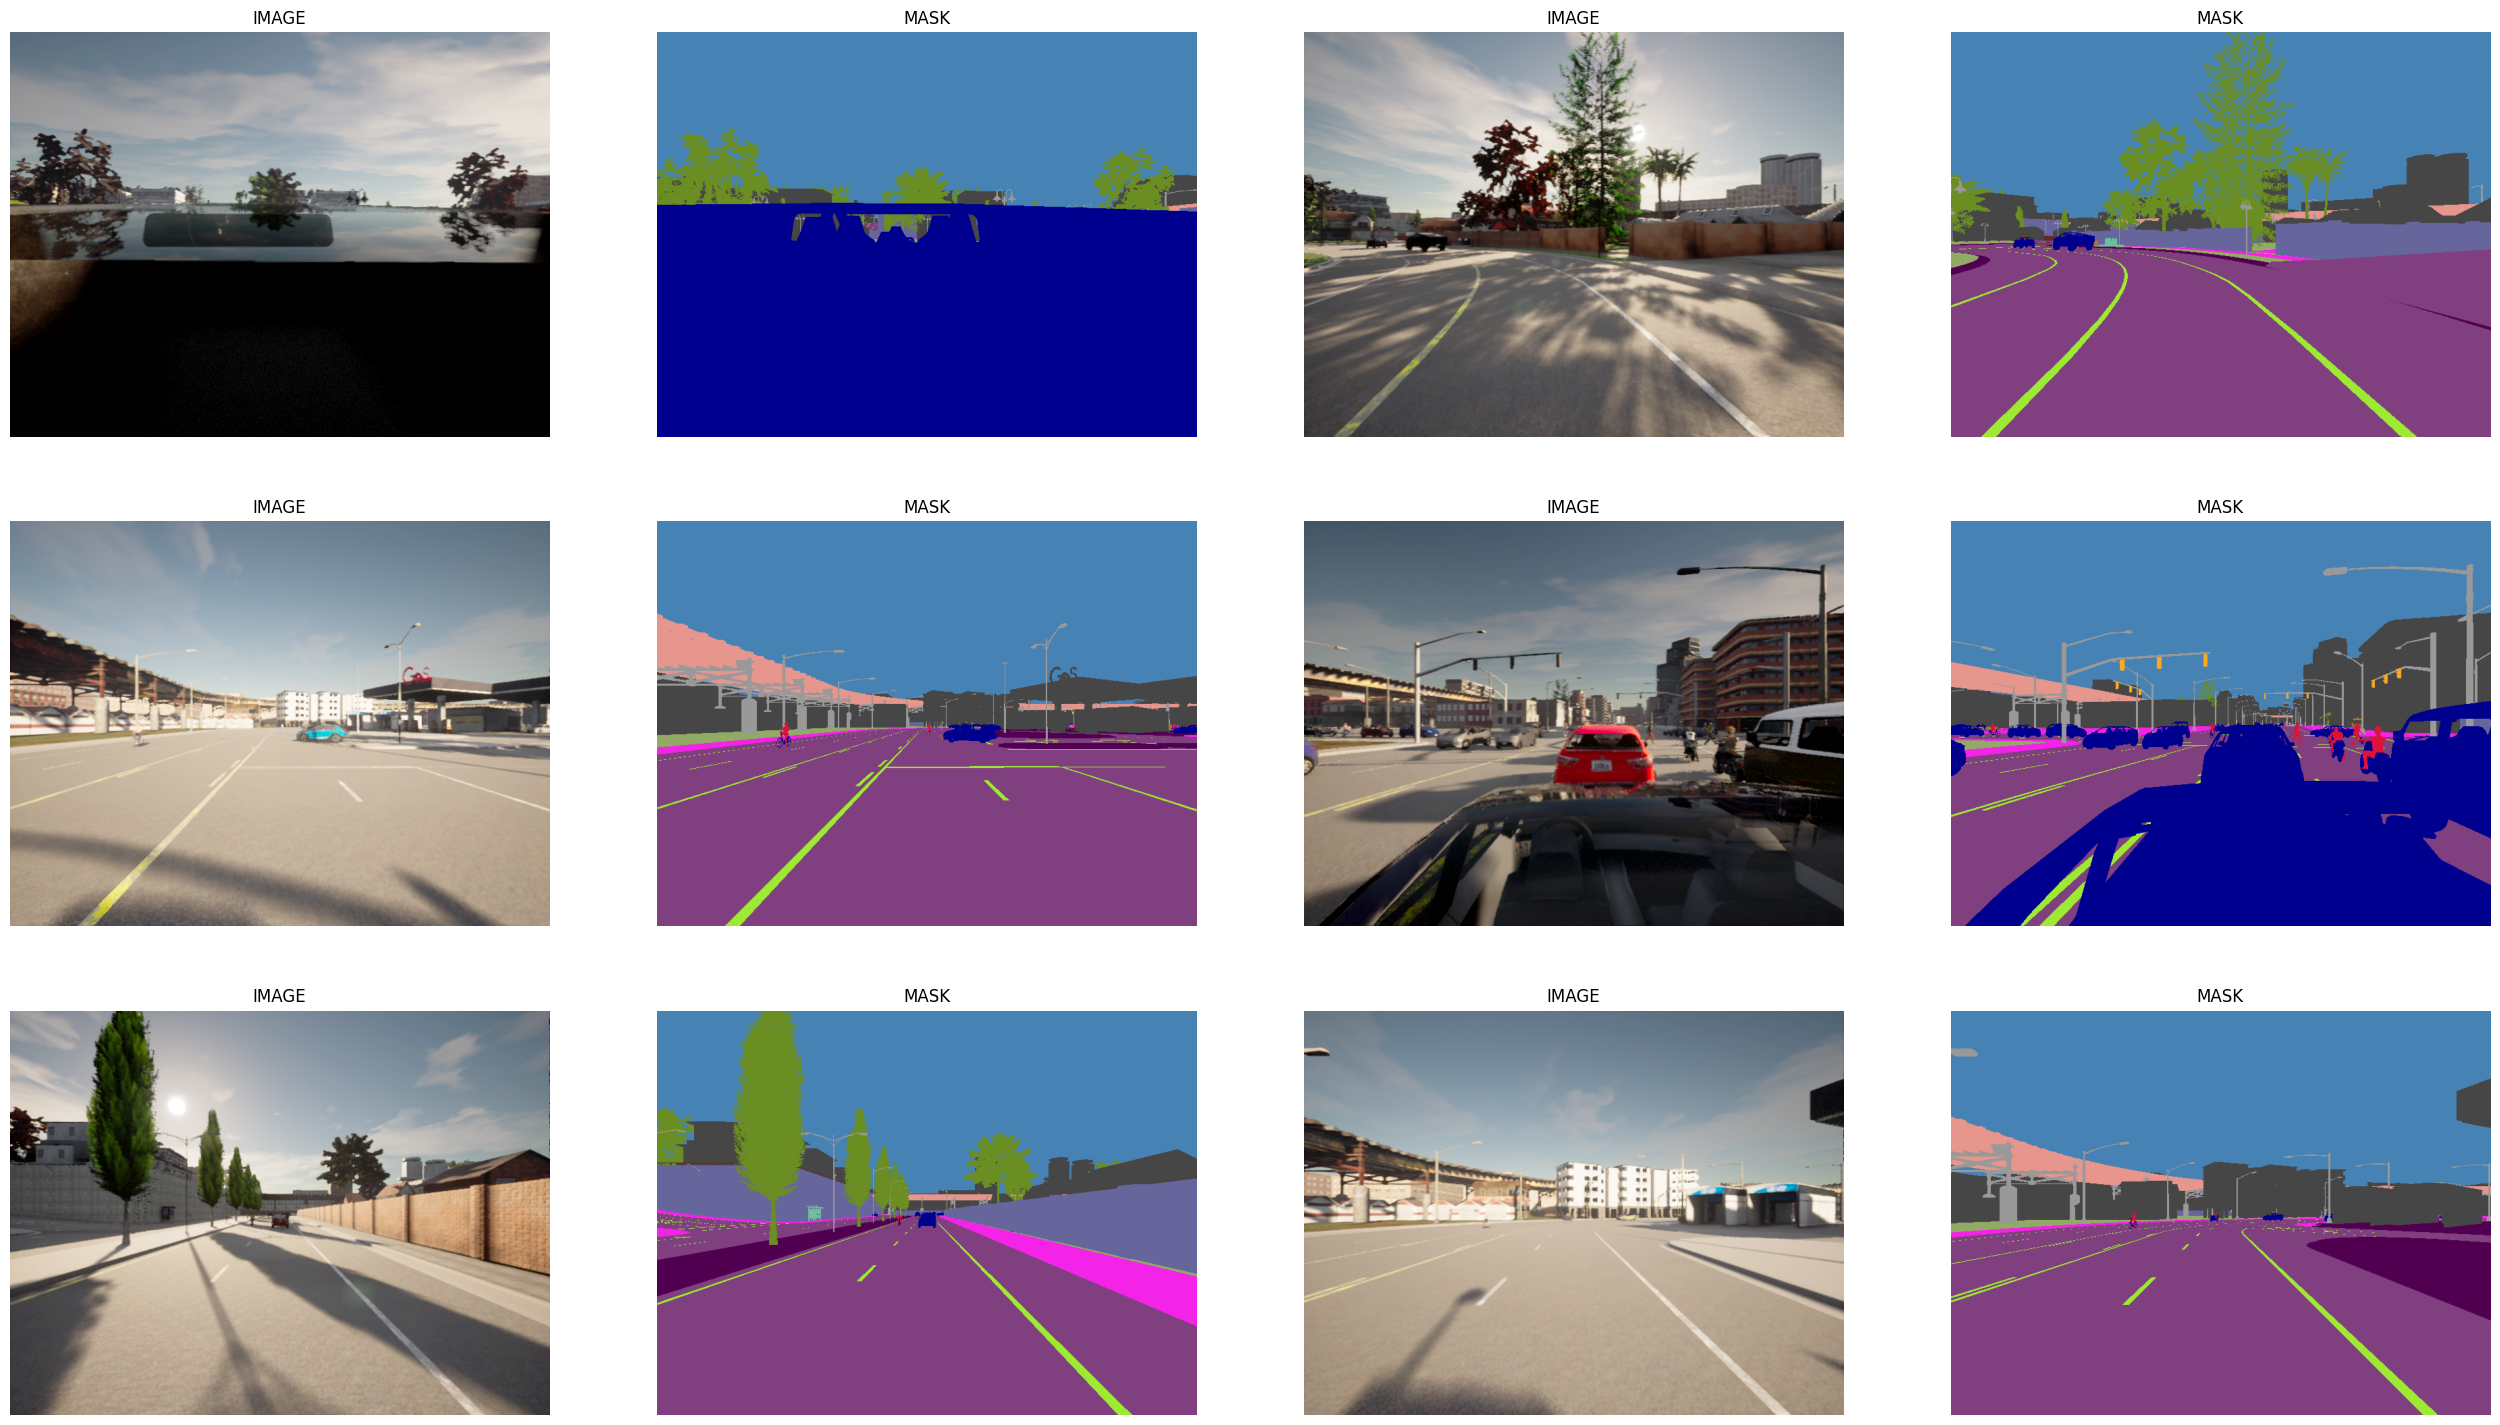

In [ ]:
def display_images_and_masks(dataframe):
    rows = 3
    cols = 4
    fig, ax = plt.subplots(rows, cols, figsize=(32, 18))
    for i in range(rows):
        for j in range(2):
            index = rn.randint(0, dataframe.shape[0] - 1)
            img_path = dataframe['image_path'][index]
            mask_path = dataframe['mask_path'][index]
            img = cv.imread(img_path)
            mask = cv.imread(mask_path)
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
            ax[i, (j * 2) + 0].imshow(img)
            ax[i, (j * 2) + 1].imshow(mask)
            ax[i, (j * 2) + 0].set_title('IMAGE')
            ax[i, (j * 2) + 1].set_title('MASK')
            ax[i, (j * 2) + 0].axis('off')
            ax[i, (j * 2) + 1].axis('off')
    plt.show()
display_images_and_masks(df)

In [ ]:
def get_unique_pixels_in_mask(x):
    mask = cv.imread(x)
    mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
    mask = np.array(mask, dtype='int32')
    mask = np.reshape(mask, newshape=(-1, 3))
    pixels = np.unique(mask, axis=0)
    return pixels.tolist()
df['PIXELS_VALUES'] = df['mask_path'].apply(lambda x: get_unique_pixels_in_mask(x))
df['LEN'] = df['PIXELS_VALUES'].apply(lambda x: len(x))
df.describe()

In [ ]:
# classes = []
# for i in range(df.shape[0]):
#     classes.extend(df['PIXELS_VALUES'][i])
# classes = np.array(classes)
# classes = np.unique(classes, axis=0)
# df = df.drop(columns=['PIXELS_VALUES', 'LEN'])
# classes = classes.tolist()
classes = [[0, 0, 142],
           [45, 60, 150],
           [70, 70, 70],
           [70, 130, 180],
           [81, 0, 81],
           [100, 40, 40],
           [102, 102, 156],
           [107, 142, 35],
           [110, 190, 160],
           [128, 64, 128],
           [145, 170, 100],
           [150, 100, 100],
           [153, 153, 153],
           [157, 234, 50],
           [170, 120, 50],
           [220, 20, 60],
           [220, 220, 0],
           [230, 150, 140],
           [244, 35, 232],
           [250, 170, 30]]
enc_class_dict = {0: [0, 0, 142],
                  1: [45, 60, 150],
                  2: [70, 70, 70],
                  3: [70, 130, 180],
                  4: [81, 0, 81],
                  5: [100, 40, 40],
                  6: [102, 102, 156],
                  7: [107, 142, 35],
                  8: [110, 190, 160],
                  9: [128, 64, 128],
                  10: [145, 170, 100],
                  11: [150, 100, 100],
                  12: [153, 153, 153],
                  13: [157, 234, 50],
                  14: [170, 120, 50],
                  15: [220, 20, 60],
                  16: [220, 220, 0],
                  17: [230, 150, 140],
                  18: [244, 35, 232],
                  19: [250, 170, 30]}

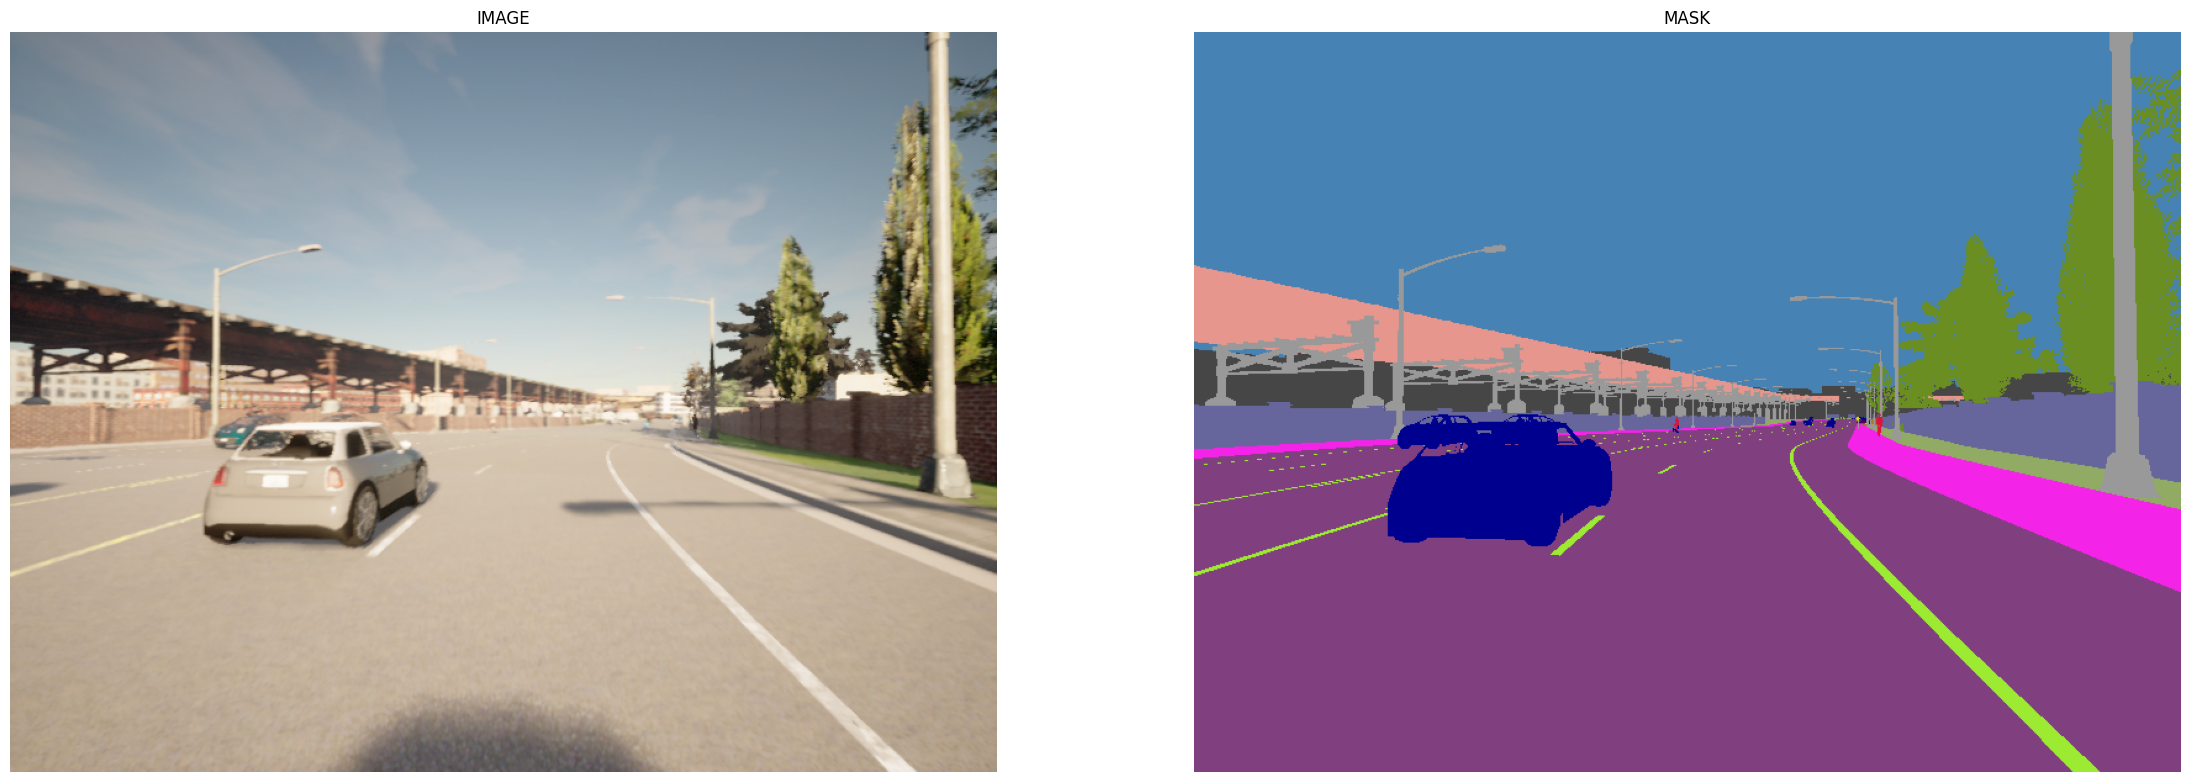

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(28, 14))
index = rn.randint(0, df.shape[0])
img_path = df['image_path'][index]
img = cv.imread(img_path)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
ax[0].imshow(img)
ax[0].set_title('IMAGE')
ax[0].axis('off')
mask_path = df['mask_path'][index]
mask = cv.imread(mask_path)
mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
ax[1].imshow(mask)
ax[1].set_title('MASK')
ax[1].axis('off')
plt.show()

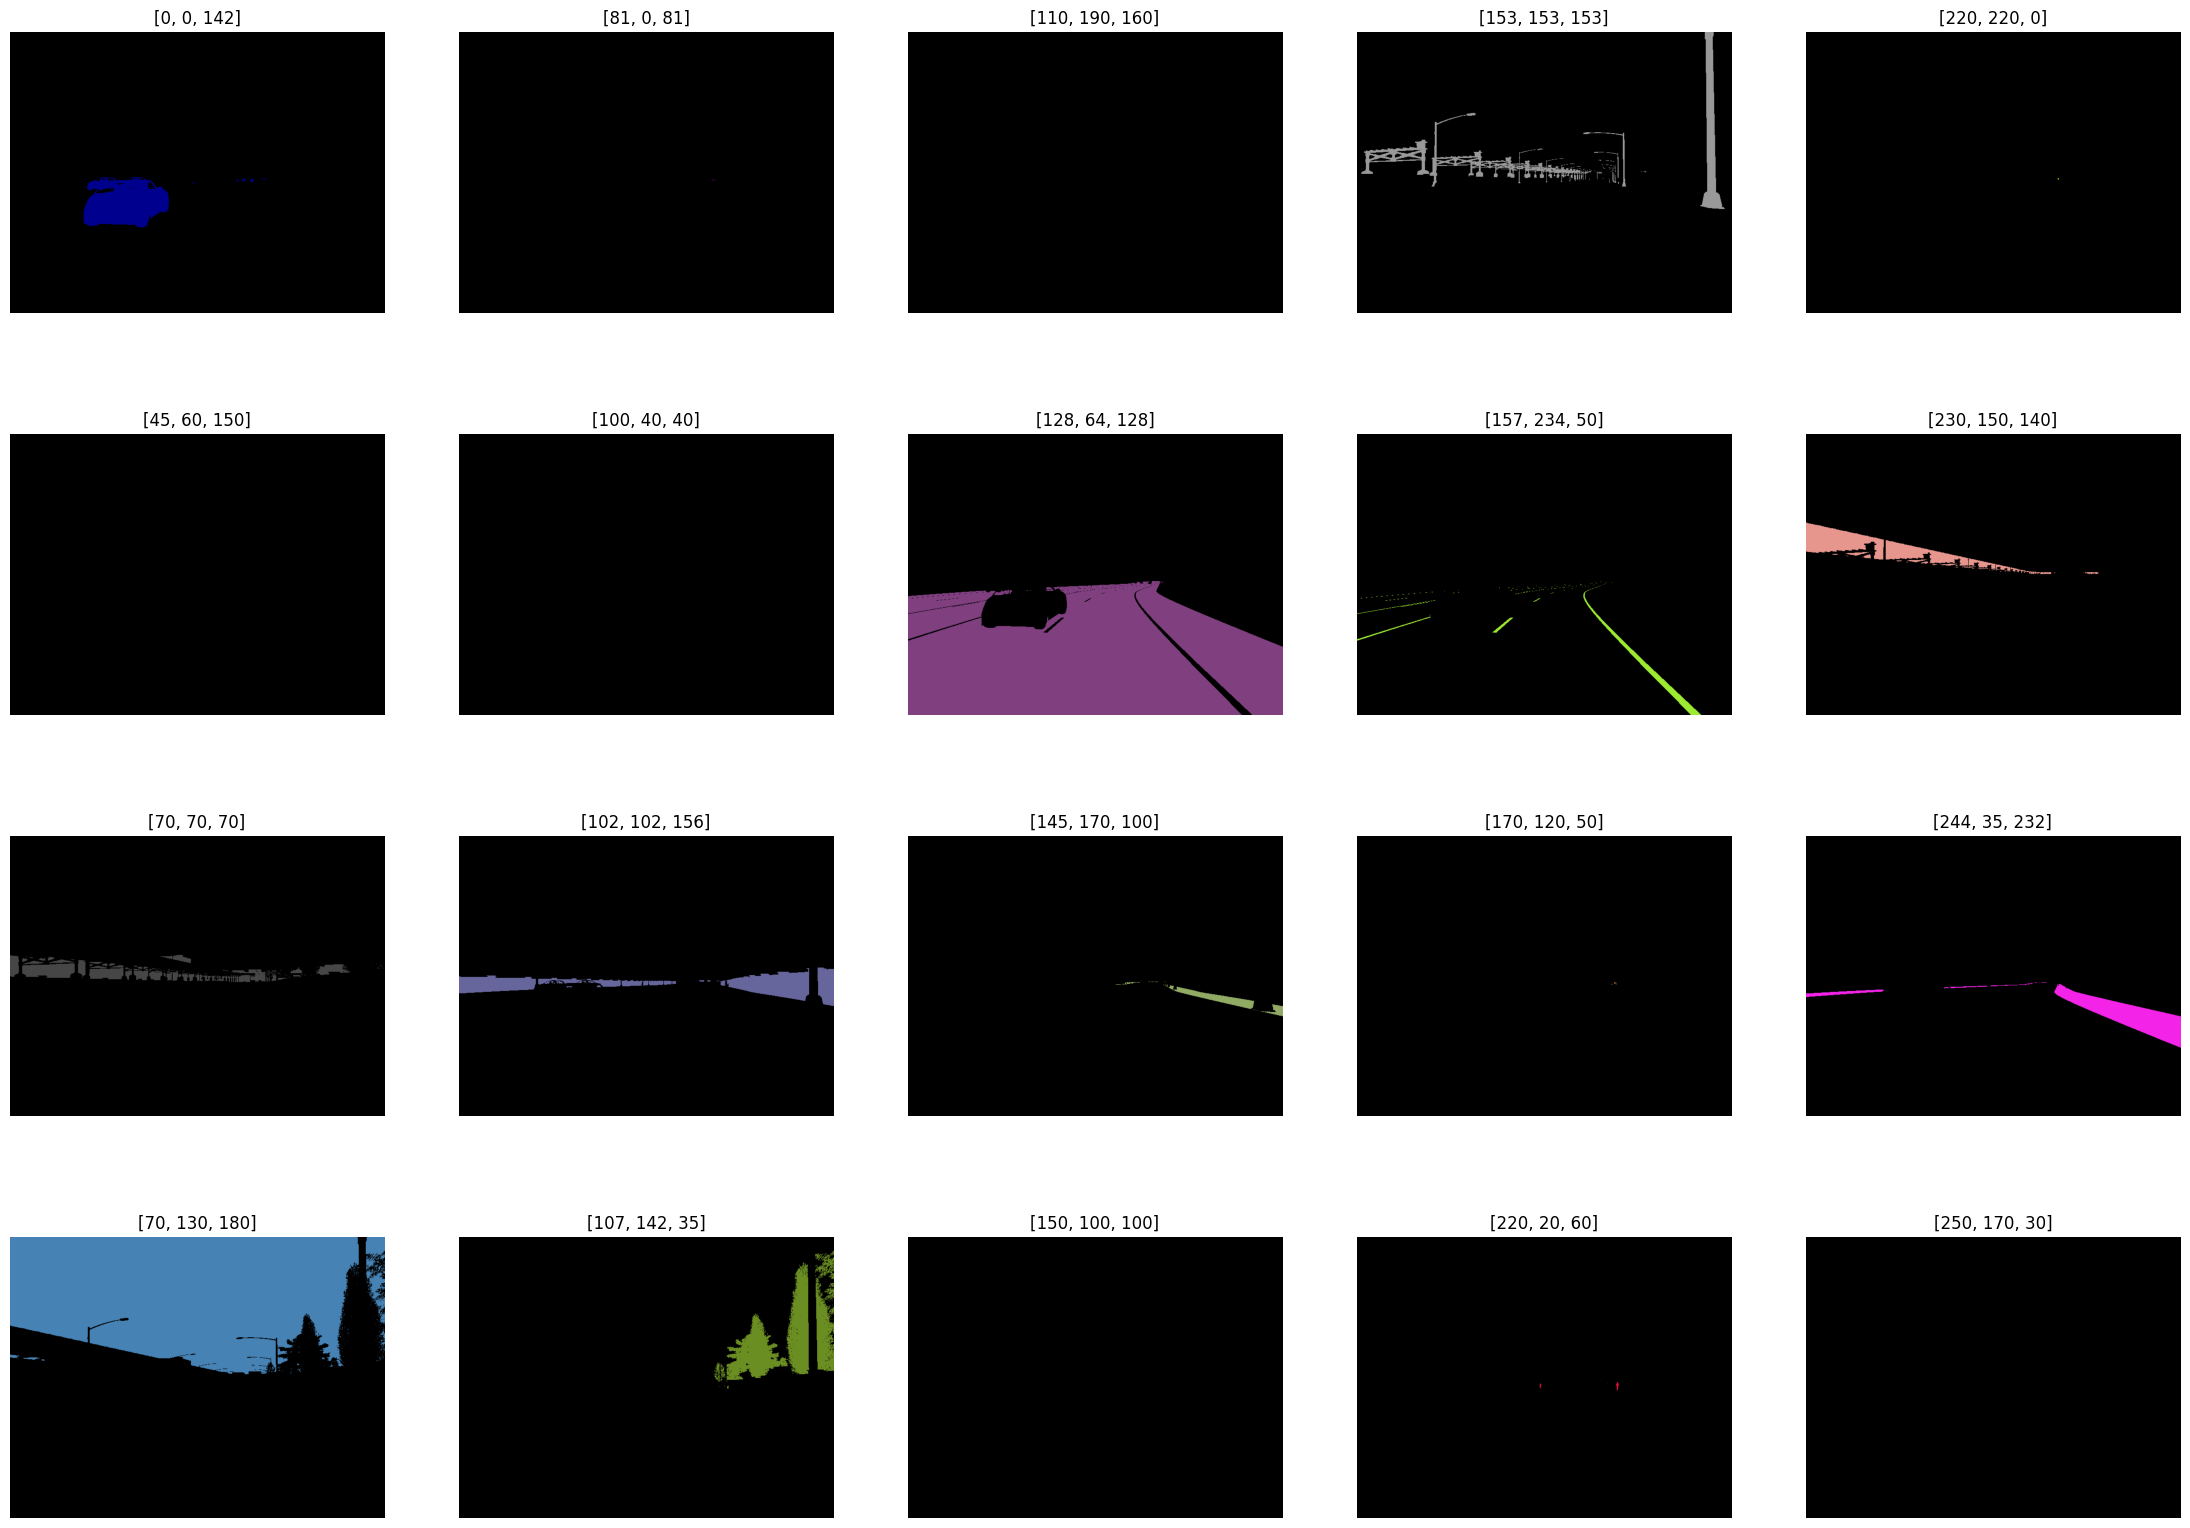

In [ ]:
def display_classes_in_img(mask, class_list):
    rows = 4
    cols = 5
    fig, ax = plt.subplots(rows, cols, figsize=(28, 20))
    mask = np.array(mask, dtype='float32')
    for index, color in enumerate(class_list):
        m = np.zeros(shape=mask.shape[:-1], dtype='float32')
        m[(mask == color).all(axis=-1)] = 1.0
        m = np.stack([m, m, m], axis=-1)
        m = m * mask
        m = np.array(m, dtype='uint8')
        j = math.floor(index / rows)
        i = index % rows
        ax[i, j].imshow(m)
        ax[i, j].set_title(f'{color}')
        ax[i, j].axis('off')
    plt.show()
display_classes_in_img(mask, classes)

In [ ]:
def random_crops(dataframe, crops_per_img, crop_h, crop_w):
    folder = f'cropped_{crop_h}x{crop_w}'
    images = []
    masks = []
    if not os.path.isdir(folder):
        os.mkdir(folder)
        os.mkdir(folder + '/images')
        os.mkdir(folder + '/masks')
    for i in range(dataframe.shape[0]):
        img_path = dataframe['image_path'][i]
        img = cv.imread(img_path)
        mask_path = dataframe['mask_path'][i]
        mask = cv.imread(mask_path)
        img_h, img_w, _ = img.shape
        for j in range(crops_per_img):
            x1 = rn.randint(0, img_w - crop_w - 1)
            y1 = rn.randint(0, img_h - crop_h - 1)
            x2 = x1 + crop_w
            y2 = y1 + crop_h
            img_crop = img[y1:y2, x1:x2]
            path = f'/content/{folder}/images/img_{i}_{j}.png'
            cv.imwrite(path, img_crop)
            images.append(path)
            mask_crop = mask[y1:y2, x1:x2]
            path = f'/content/{folder}/masks/mask_{i}_{j}.png'
            cv.imwrite(path, mask_crop)
            masks.append(path)
    return pd.DataFrame({'image_path': images, 'mask_path': masks})

In [ ]:
H, W, C = 384, 512, 3
folder = f'/content/cropped_{H}x{W}'
if os.path.isdir(folder):
    images = sorted(os.listdir(f'{folder}/images'))
    masks = sorted(os.listdir(f'{folder}/masks'))
    df = pd.DataFrame({'image_path': images, 'mask_path': masks})
    df['image_path'] = f'{folder}/images/' + df['image_path'].astype(str)
    df['mask_path'] = f'{folder}/masks/' + df['mask_path'].astype(str)
else:
    df = random_crops(df, 3, H, W)
df.head()

image_path  \
0     /content/cropped_384x512/images/img_0_0.png   
1     /content/cropped_384x512/images/img_0_1.png   
2     /content/cropped_384x512/images/img_0_2.png   
3  /content/cropped_384x512/images/img_1000_0.png   
4  /content/cropped_384x512/images/img_1000_1.png   

                                        mask_path  
0     /content/cropped_384x512/masks/mask_0_0.png  
1     /content/cropped_384x512/masks/mask_0_1.png  
2     /content/cropped_384x512/masks/mask_0_2.png  
3  /content/cropped_384x512/masks/mask_1000_0.png  
4  /content/cropped_384x512/masks/mask_1000_1.png

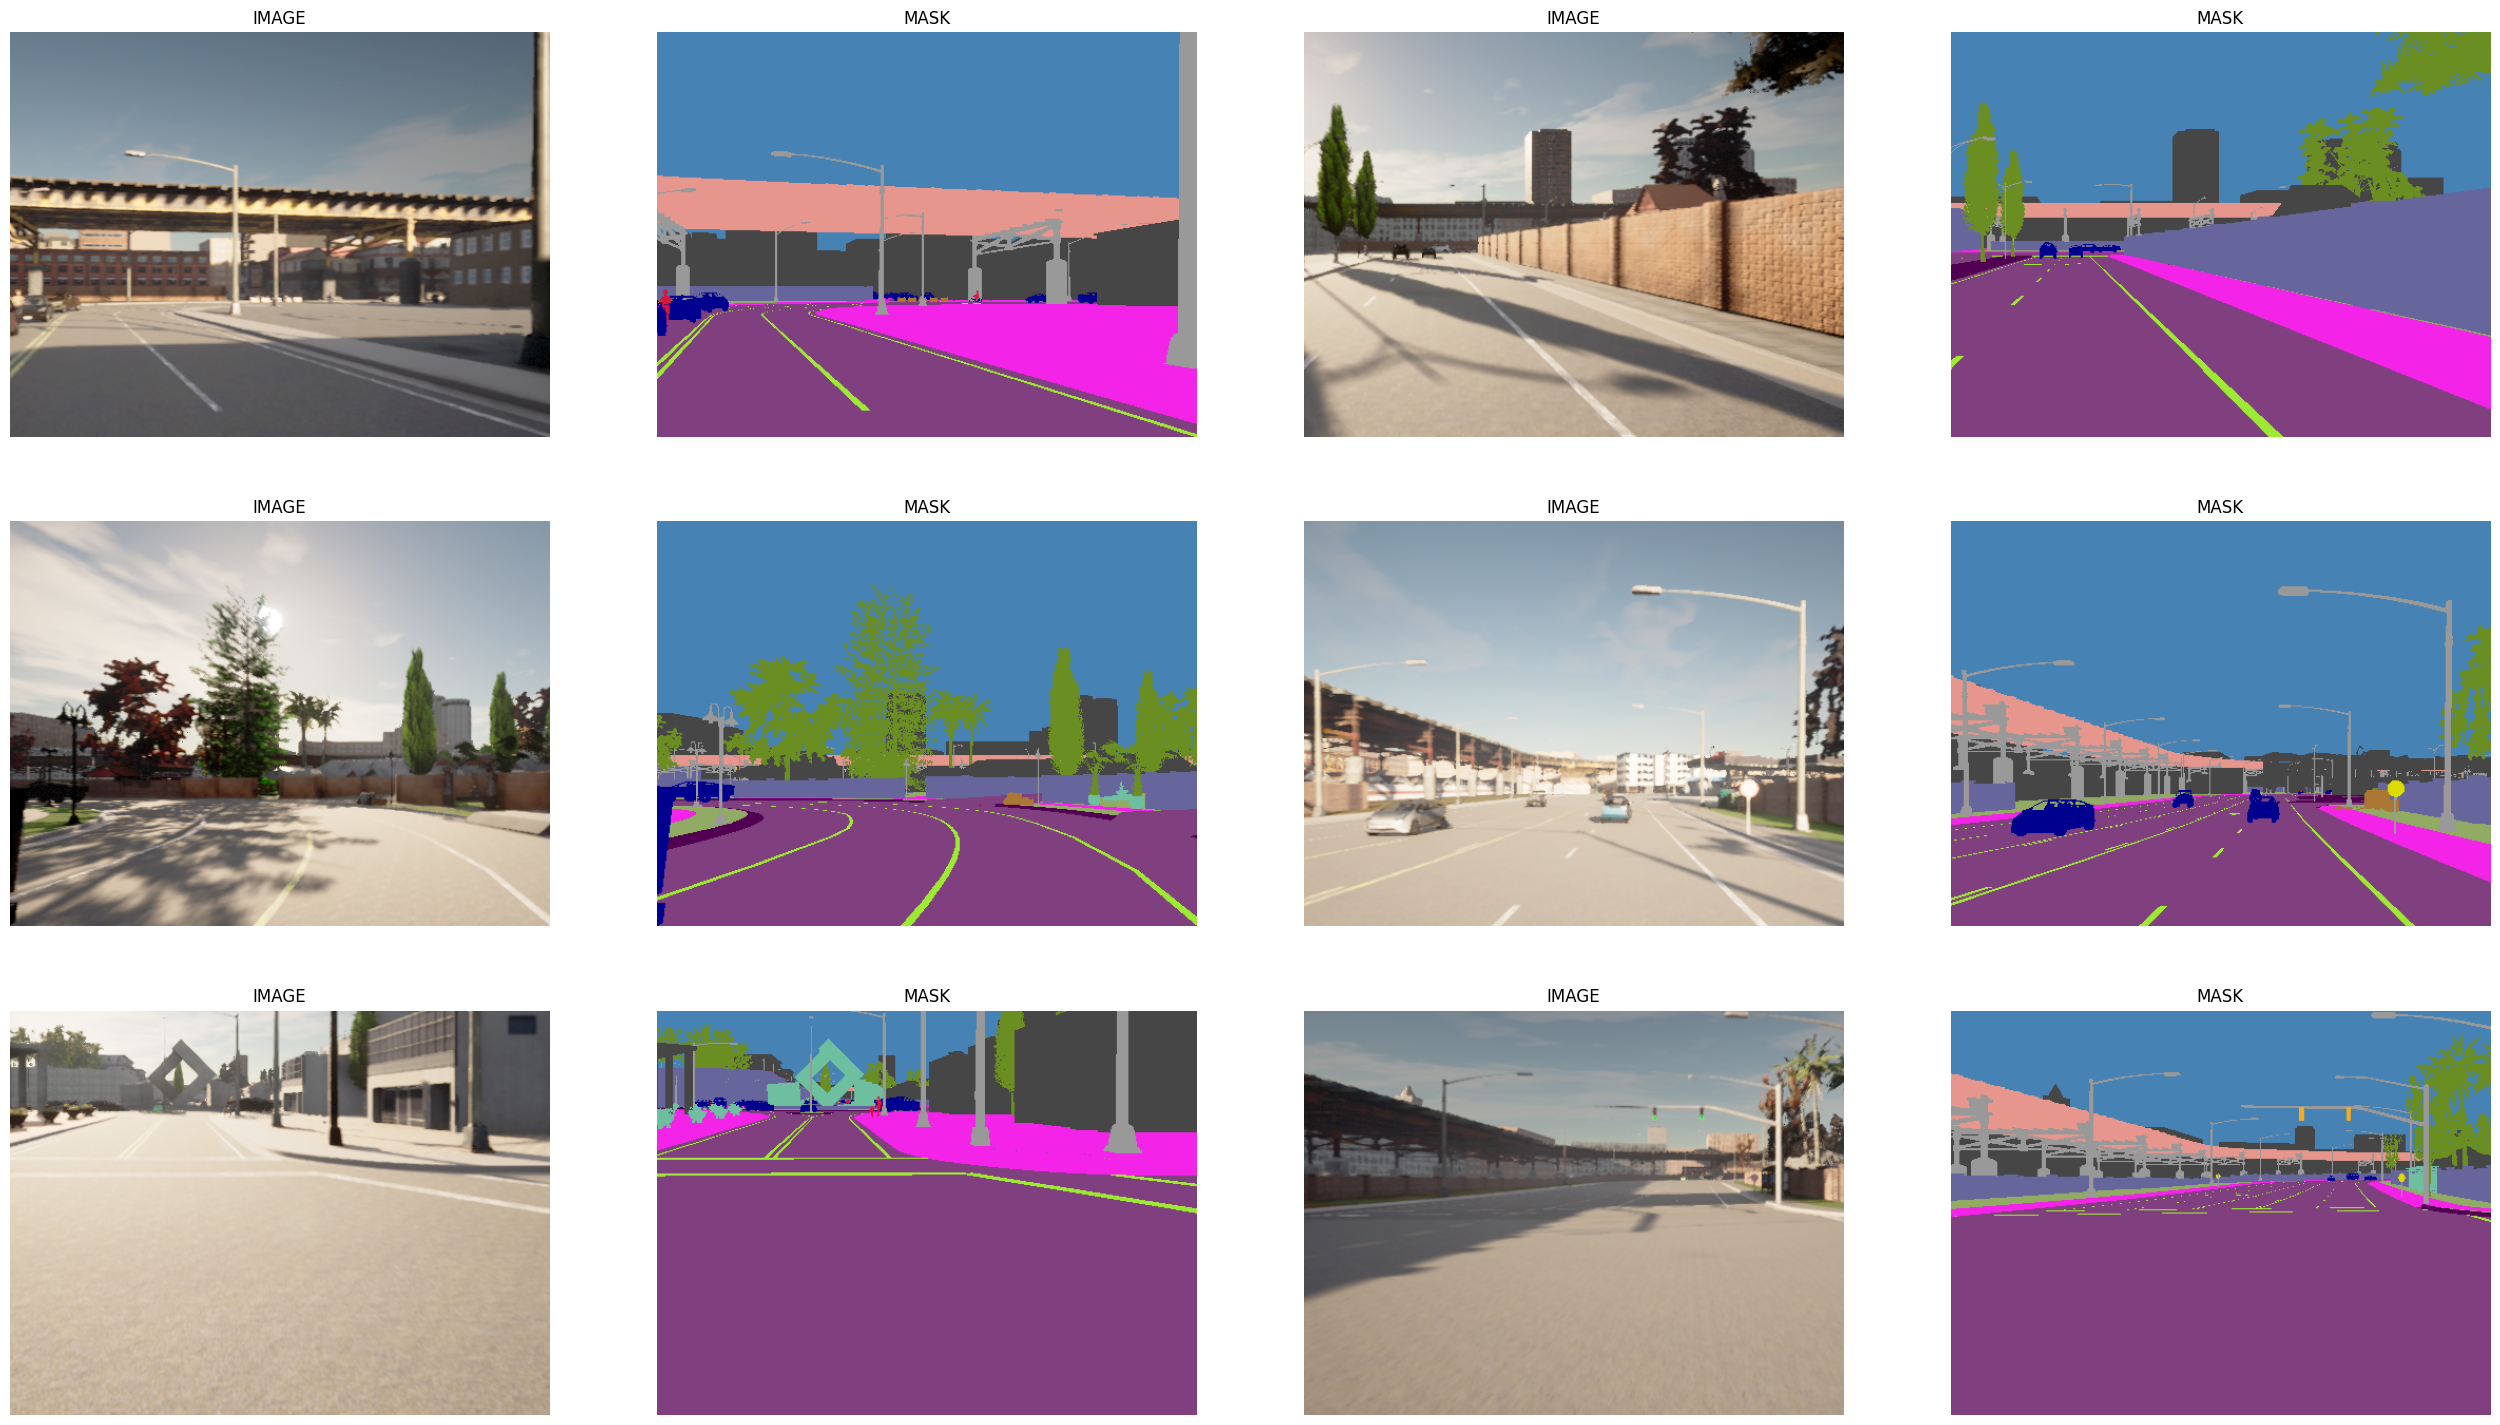

In [ ]:
display_images_and_masks(df)

In [ ]:
df.shape

(4362, 2)

In [ ]:
val_df, train_df = train_test_split(df, test_size=4000/4362, random_state=24)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=9)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
train_df.shape, val_df.shape, test_df.shape

((4000, 2), (181, 2), (181, 2))

In [ ]:
class Pipeline(tf.keras.utils.Sequence):
    def __init__(self, dataframe, x, y, batch_size, h, w, c, class_list):
        self.dataframe = dataframe
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.h = h
        self.w = w
        self.c = c
        self.class_list = class_list

    def __len__(self):
        return math.floor(self.dataframe.shape[0] / self.batch_size)

    def on_epoch_end(self):
        self.dataframe = self.dataframe.sample(frac=1)
        self.dataframe.reset_index(drop=True, inplace=True)

    def transform_mask(self, mask):
        masks = []
        for color in self.class_list:
            m = (mask == color).all(axis=-1)
            masks.append(m)
        masks = np.stack(masks, axis=-1)
        masks = np.array(masks, dtype='float32')
        return masks

    def __getitem__(self, item):
        X = []
        Y = []
        for i in range(self.batch_size):
            img_path = self.dataframe[self.x][i + (self.batch_size * item)]
            img = cv.imread(img_path)
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = np.array(img, dtype='float32')
            img = img / 255.0
            img = np.expand_dims(img, axis=0)
            X.append(img)
            mask_path = self.dataframe[self.y][i + (self.batch_size * item)]
            mask = cv.imread(mask_path)
            mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
            mask = self.transform_mask(mask)
            mask = np.expand_dims(mask, axis=0)
            Y.append(mask)
        X = np.concatenate(X, axis=0)
        Y = np.concatenate(Y, axis=0)
        return X, Y
B = 16
H, W, C = 384, 512, 3
train_gen = Pipeline(train_df, 'image_path', 'mask_path', B, H, W, C, classes)
val_gen = Pipeline(val_df, 'image_path', 'mask_path', B, H, W, C, classes)
test_gen = Pipeline(test_df, 'image_path', 'mask_path', B, H, W, C, classes)
train_gen.__getitem__(0)[0].shape, train_gen.__getitem__(0)[1].shape

((16, 384, 512, 3), (16, 384, 512, 20))

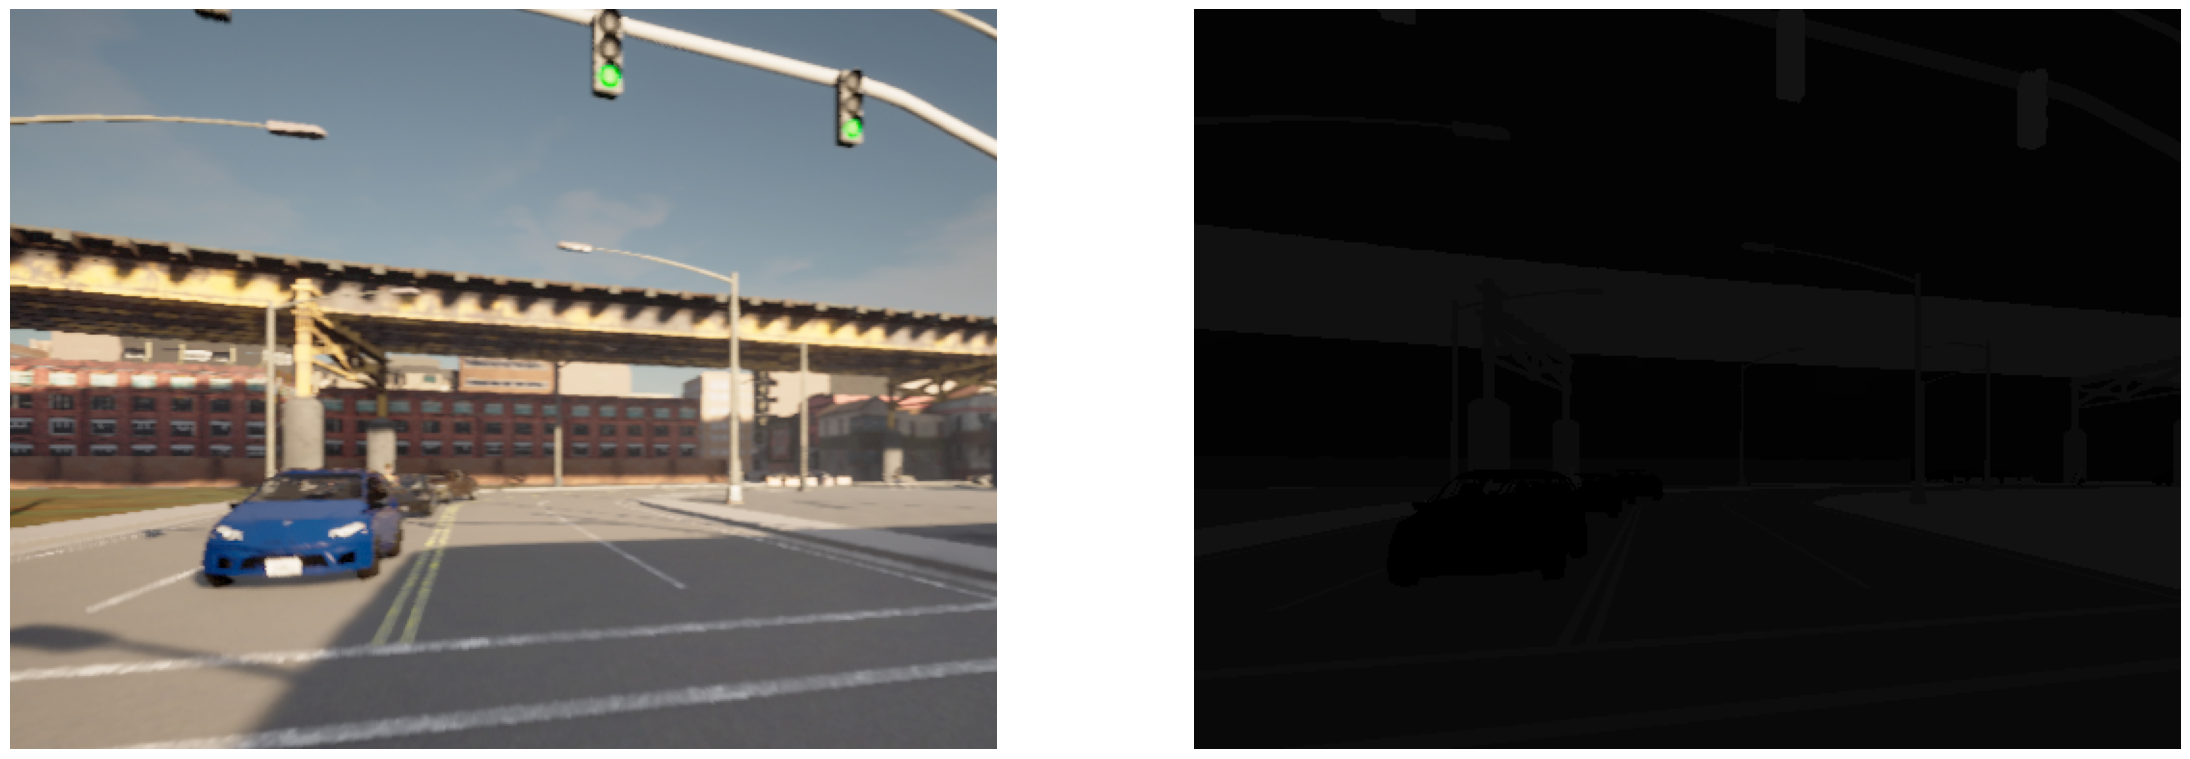

In [ ]:
def display_gen(gen, enc_dict):
    x, y = gen.__getitem__(0)
    fig, ax = plt.subplots(1, 2, figsize=(28, 10))
    img = x[0]
    img = img * 255.0
    img = np.array(img, dtype='int32')
    img = np.array(img, dtype='uint8')
    ax[0].imshow(img)
    ax[0].axis('off')
    m = np.zeros(shape=(img.shape[0], img.shape[1], 3), dtype='int32')
    mask = y[0]
    mask = np.argmax(mask, axis=-1)
    for enc in enc_dict:
        m[mask == enc] = enc_dict[enc]
    mask = np.array(mask, dtype='uint8')
    mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
    ax[1].imshow(mask)
    ax[1].axis('off')
    plt.show()
display_gen(train_gen, enc_class_dict)

In [ ]:
X_inp = tf.keras.Input(shape=(H, W, C))
# (384, 512, 3)
base = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_tensor=X_inp)
s1 = base.get_layer('block1_conv2').output # (384, 512, 64)
s2 = base.get_layer('block2_conv2').output # (192, 256, 128)
s3 = base.get_layer('block3_conv4').output # (96, 128, 256)
s4 = base.get_layer('block4_conv4').output # (48, 64, 512)
s5 = base.get_layer('block5_conv4').output # (24, 32, 512)
X = base.output
# (12, 16, 512)
X = tf.keras.layers.Conv2D(1024, kernel_size=3, padding='same')(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Activation('relu')(X)
# (12, 16, 1024)
X = tf.keras.layers.Conv2D(512, kernel_size=3, padding='same')(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Activation('relu')(X)
X = tf.keras.layers.UpSampling2D(size=2, interpolation='bilinear')(X)
X = tf.keras.layers.Concatenate(axis=-1)([X, s5])
# (24, 32, 1024)
X = tf.keras.layers.Conv2D(512, kernel_size=3, padding='same')(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Activation('relu')(X)
X = tf.keras.layers.UpSampling2D(size=2, interpolation='bilinear')(X)
X = tf.keras.layers.Concatenate(axis=-1)([X, s4])
# (48, 64, 1024)
X = tf.keras.layers.Conv2D(256, kernel_size=3, padding='same')(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Activation('relu')(X)
X = tf.keras.layers.UpSampling2D(size=2, interpolation='bilinear')(X)
X = tf.keras.layers.Concatenate(axis=-1)([X, s3])
# (96, 128, 512)
X = tf.keras.layers.Conv2D(128, kernel_size=3, padding='same')(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Activation('relu')(X)
X = tf.keras.layers.UpSampling2D(size=2, interpolation='bilinear')(X)
X = tf.keras.layers.Concatenate(axis=-1)([X, s2])
# (192, 256, 256)
X = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same')(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Activation('relu')(X)
X = tf.keras.layers.UpSampling2D(size=2, interpolation='bilinear')(X)
X = tf.keras.layers.Concatenate(axis=-1)([X, s1])
# (384, 512, 128)
X = tf.keras.layers.Conv2D(len(classes), kernel_size=1, padding='same', activation='softmax')(X)
# (384, 512, 20)
model1 = tf.keras.Model(inputs=X_inp, outputs=X)
model1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 384, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 384, 512, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 384, 512, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 192, 256, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 192, 256, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 192, 256, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 96, 128, 128)   │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 96, 128, 256)   │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 96, 128, 256)   │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 96, 128, 256)   │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv4 (Conv2D)     │ (None, 96, 128, 256)   │        590,080 │ block3_conv3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 48, 64, 256)    │              0 │ block3_conv4[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 48, 64, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 48, 64, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 48, 64, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv4 (Conv2D)     │ (None, 48, 64, 512)    │      2,359,808 │ block4_conv3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 24, 32, 512)    │              0 │ block4_conv4[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)

 Total params: 37,291,796 (142.26 MB)

 Trainable params: 37,286,804 (142.24 MB)

 Non-trainable params: 4,992 (19.50 KB)

In [ ]:
class CustomMetric(tf.keras.metrics.Metric):
    def __init__(self, num_classes):
        super(CustomMetric, self).__init__(name='custom_metric', dtype=tf.float32)
        self.num_classes = num_classes
        self.p = self.add_weight(name='precision', initializer='zeros')
        self.r = self.add_weight(name='recall', initializer='zeros')
        self.a = self.add_weight(name='accuracy', initializer='zeros')
        self.f = self.add_weight(name='f1', initializer='zeros')
        self.s = self.add_weight(name='sample', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_true = tf.reshape(y_true, shape=[-1])
        y_pred = tf.argmax(y_pred, axis=-1)
        y_pred = tf.reshape(y_pred, shape=[-1])

        cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=self.num_classes)
        cm = tf.cast(cm, dtype=tf.float32)

        tp = tf.linalg.diag_part(cm)
        tp_fp = tf.reduce_sum(cm, axis=-1)
        tp_fn = tf.reduce_sum(cm, axis=0)

        prec = tp / tp_fp
        rec = tp / tp_fn
        acc = tf.reduce_sum(tp) / tf.reduce_sum(cm)
        f1 = (2 * prec * rec) / (prec + rec)

        prec = tf.where(tf.math.is_nan(prec), 0.0, prec)
        rec = tf.where(tf.math.is_nan(rec), 0.0, rec)
        acc = tf.where(tf.math.is_nan(acc), 0.0, acc)
        f1 = tf.where(tf.math.is_nan(f1), 0.0, f1)

        mean_prec = tf.reduce_mean(prec)
        mean_rec = tf.reduce_mean(rec)
        mean_f1 = tf.reduce_mean(f1)

        self.p.assign_add(mean_prec)
        self.r.assign_add(mean_rec)
        self.a.assign_add(acc)
        self.f.assign_add(mean_f1)
        self.s.assign_add(1.0)

    def result(self):
        return {'mean_precision': self.p / self.s, 'mean_recall': self.r / self.s, 'accuracy': self.a / self.s, 'mean_f1': self.f / self.s}

    def reset_state(self):
        self.p.assign(0.)
        self.r.assign(0.)
        self.a.assign(0.)
        self.f.assign(0.)
        self.s.assign(0.)
metric = CustomMetric(len(classes))

In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataframe, x, y, class_dict):
        super(CustomCallback, self).__init__()
        self.dataframe = dataframe
        self.x = x
        self.y = y
        self.class_dict = class_dict

    def on_epoch_end(self, epoch, logs=None):
        fig, ax = plt.subplots(1, 3, figsize=(28, 12))
        index = rn.randint(0, self.dataframe.shape[0] - 1)
        mask = self.dataframe[self.y][index]
        mask = cv.imread(mask)
        mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
        ax[0].imshow(mask)
        ax[0].set_title('TRUE MASK')
        ax[0].axis('off')
        img = self.dataframe[self.x][index]
        img = cv.imread(img)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        ax[1].imshow(img)
        ax[1].set_title('INPUT IMAGE')
        ax[1].axis('off')
        pred = np.array(img, dtype='float32')
        pred = pred / 255.0
        pred = np.expand_dims(pred, axis=0)
        pred = self.model.predict(pred)
        pred = np.squeeze(pred, axis=0)
        pred = np.argmax(pred, axis=-1)
        pred = np.expand_dims(pred, axis=-1)
        pred = np.array(pred, dtype='int32')
        p = np.zeros(shape=(pred.shape[0], pred.shape[1], 3), dtype='int32')
        for color in self.class_dict:
            index = (pred == color).all(axis=-1)
            p[index] = self.class_dict[color]
        p = np.array(p, dtype='uint8')
        ax[2].imshow(p)
        ax[2].set_title('PRED MASK')
        ax[2].axis('off')
        plt.show()
cc = CustomCallback(val_df, 'image_path', 'mask_path', enc_class_dict)

In [ ]:
E = 20
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=6, restore_best_weights=True)
mc = tf.keras.callbacks.ModelCheckpoint(filepath='weights.keras', monitor='val_loss', mode='min', save_best_only=True)
rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=3, factor=0.4)
mean_iou = tf.keras.metrics.MeanIoU(num_classes=len(classes), dtype=tf.float32, sparse_y_true=False, sparse_y_pred=False)
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
               loss='categorical_crossentropy',
               metrics=[mean_iou, metric])
fit1 = model1.fit(train_gen,
                  batch_size=B,
                  epochs=E,
                  callbacks=[es, mc, rlrop, cc],
                  validation_data=val_gen,
                  validation_batch_size=B)

In [ ]:
tf.keras.models.save_model(model1, '/content/model1', save_format='tf')
model1.evaluate(test_gen, batch_size=B)

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(28, 28))

ax[0, 0].plot(fit1.history['loss'], label='train_loss')
ax[0, 0].plot(fit1.history['val_loss'], label='val_loss')
ax[0, 0].set_xlabel('EPOCHS')
ax[0, 0].set_ylabel('LOSS')
ax[0, 0].set_title('LOSS VS. EPOCHS')
ax[0, 0].legend()

ax[0, 1].plot(fit1.history['mean_io_u'], label='train_mean_io_u')
ax[0, 1].plot(fit1.history['val_mean_io_u'], label='val_mean_io_u')
ax[0, 1].set_xlabel('EPOCHS')
ax[0, 1].set_ylabel('MEAN IO_U')
ax[0, 1].set_title('MEAN IO_U VS. EPOCHS')
ax[0, 1].legend()

ax[1, 0].plot(fit1.history['mean_precision'], label='train_precision')
ax[1, 0].plot(fit1.history['val_mean_precision'], label='val_precision')
ax[1, 0].set_xlabel('EPOCHS')
ax[1, 0].set_ylabel('PRECISION')
ax[1, 0].set_title('PRECISION VS. EPOCHS')
ax[1, 0].legend()

ax[1, 1].plot(fit1.history['mean_recall'], label='train_mean_recall')
ax[1, 1].plot(fit1.history['val_mean_recall'], label='val_mean_recall')
ax[1, 1].set_xlabel('EPOCHS')
ax[1, 1].set_ylabel('RECALL')
ax[1, 1].set_title('RECALL VS. EPOCHS')
ax[1, 1].legend()

ax[2, 0].plot(fit1.history['accuracy'], label='train_accuracy')
ax[2, 0].plot(fit1.history['val_accuracy'], label='val_accuracy')
ax[2, 0].set_xlabel('EPOCHS')
ax[2, 0].set_ylabel('ACCURACY')
ax[2, 0].set_title('ACCURACY VS. EPOCHS')
ax[2, 0].legend()

ax[2, 1].plot(fit1.history['mean_f1'], label='train_mean_f1')
ax[2, 1].plot(fit1.history['val_mean_f1'], label='val_mean_f1')
ax[2, 1].set_xlabel('EPOCHS')
ax[2, 1].set_ylabel('F1 SCORE')
ax[2, 1].set_title('F1 SCORE VS. EPOCHS')
ax[2, 1].legend()
plt.show()

In [ ]:
# !zip -r /content/model.zip /content/model1
from google.colab import files
# files.download('/content/model.zip')
files.download('/content/weights.keras')

In [ ]:
def predict_mask(from_path, image_path, image, model_path):
    classes = [[0, 0, 142], [45, 60, 150], [70, 70, 70], [70, 130, 180], [81, 0, 81], [100, 40, 40], [102, 102, 156],
               [107, 142, 35], [110, 190, 160], [128, 64, 128], [145, 170, 100], [150, 100, 100], [153, 153, 153],
               [157, 234, 50], [170, 120, 50], [220, 20, 60], [220, 220, 0], [230, 150, 140], [244, 35, 232],
               [250, 170, 30]]
    if from_path:
        img = cv.imread(image_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    else:
        img = image
    img = cv.resize(img, (512, 384))
    img = np.array(img, dtype='float32')
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    model = tf.keras.models.load_model(model_path, compile=False)
    pred = model.predict(img)
    pred = np.squeeze(pred, axis=0)
    pred = np.argmax(pred, axis=-1)
    pred = np.expand_dims(pred, axis=-1)
    pred = np.array(pred, dtype='int32')
    p = np.zeros(shape=(pred.shape[0], pred.shape[1], 3), dtype='int32')
    for i, color in enumerate(classes):
        index = (pred == i).all(axis=-1)
        p[index] = color
    p = np.array(p, dtype='uint8')
    return p

In [ ]:
def predict_bbox(image, mask, min_area, k, t1, t2, colors):
    mask = cv.copyMakeBorder(mask, 3, 3, 3, 3, cv.BORDER_CONSTANT)
    image = cv.copyMakeBorder(image, 3, 3, 3, 3, cv.BORDER_CONSTANT)
    mask = np.array(mask, dtype='int32')
    for color in colors:
        m = np.zeros(shape=mask.shape[:-1], dtype='int32')
        m[(mask == color).all(axis=-1)] = 255
        m = np.stack([m, m, m], axis=-1)
        m = np.array(m, dtype='uint8')
        kernel = np.ones(shape=(k, k))
        m = cv.dilate(m, kernel, iterations=2)
        m = cv.erode(m, kernel, iterations=1)
        canny = cv.Canny(m, t1, t2)
        contours, _ = cv.findContours(canny, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
        if len(contours) != 0:
            for i, contour in enumerate(contours):
                area = cv.contourArea(contour)
                if area > min_area:
                    x1, y1, w, h = cv.boundingRect(contour)
                    image = cv.rectangle(image, (x1, y1), (x1 + w, y1 + h), color, 2)
    return image

In [ ]:
image = cv.imread('')
mask = predict_mask(from_path=False, image=image, model_path='/content/weights.keras')
new_image = predict_bbox(image, mask, 35, 3, 10, 100, [[142, 0, 0], [160, 190, 110], [153, 153, 153], [40, 40, 100], [140, 150, 230], [70, 70, 70], [156, 102, 102], [35, 142, 107], [60, 20, 220]])
filename = ''.join(rn.choices(list('abcdefghijklmnopqrstuvwxyz'), k=5))
cv.imwrite(filename + '_image.png', image)
cv.imwrite(filename + '_mask.png', mask)
cv.imwrite(filename + '_bbox.png', new_image)